In [1]:
require 'nn'
require 'cunn'
require 'cudnn'

In [48]:
dataset = '/home/coldmoon/Developer/fb.resnet.torch/gen/mnist42x42_train_center_test_ST.t7'
data = torch.load(dataset)
val = data['val']['data']/256
labels = data['val']['labels']

filename = '/home/coldmoon/Desktop/pstn/mnistscaled42x42-siconvnet-0.3-1.42/train-center-test-ST/PSTN3-Cardinal-test/C8/pstn-c8_RSampling8-siamese-autopadding-switchminmin-minmin_mnist42x42_train_center_test_ST_20170703_10_01/model/model_best.t7'
model = torch.load(filename)

In [4]:
-- forward the whole val data
batch_size = 100
iters = val:size(1)/batch_size

res = torch.zeros(val:size(1), 10)
for i = 1, iters do
    model:type('torch.CudaTensor')
    model.__memoryOptimized = nil
    model:evaluate()
    x = val[{{batch_size * (i - 1) + 1, batch_size * i}, {}}]:cuda()
    local o = model:forward(x):float()
    res[{{batch_size * (i - 1) + 1, batch_size * i}, {}}] = o
end

_ , predictions = res:topk(5, 2, true, true)

labels:type('torch.IntTensor')
predictions:type('torch.LongTensor')
print(labels:type())
print(predictions:type())

In [7]:
-- top-1 error rate
correct = predictions:eq(labels:long():view(val:size(1), 1):expandAs(predictions))
incorrect = predictions:ne(labels:long():view(val:size(1), 1):expandAs(predictions))

top1 = 1.0 - (correct:narrow(2, 1, 1):sum() / val:size(1))
print(top1)
acc1 = 1.0 - (incorrect:narrow(2, 1, 1):sum() / val:size(1))
print(acc1)

In [9]:
-- error rate for each class
incorrect_labels = labels[incorrect:narrow(2, 1, 1)]
statics = torch.zeros(10)
for i = 1, incorrect_labels:size(1) do
    statics[incorrect_labels[i]] = statics[incorrect_labels[i]] + 1
end
for i = 1, 10 do
    print(i - 1, ': ', statics[i])
end

0	: 	27	
1	: 	14	
2	: 	34	
3	: 	41	
4	: 	32	
5	: 	43	
6	: 	37	
7	: 	52	
8	: 	51	
9	: 	84	


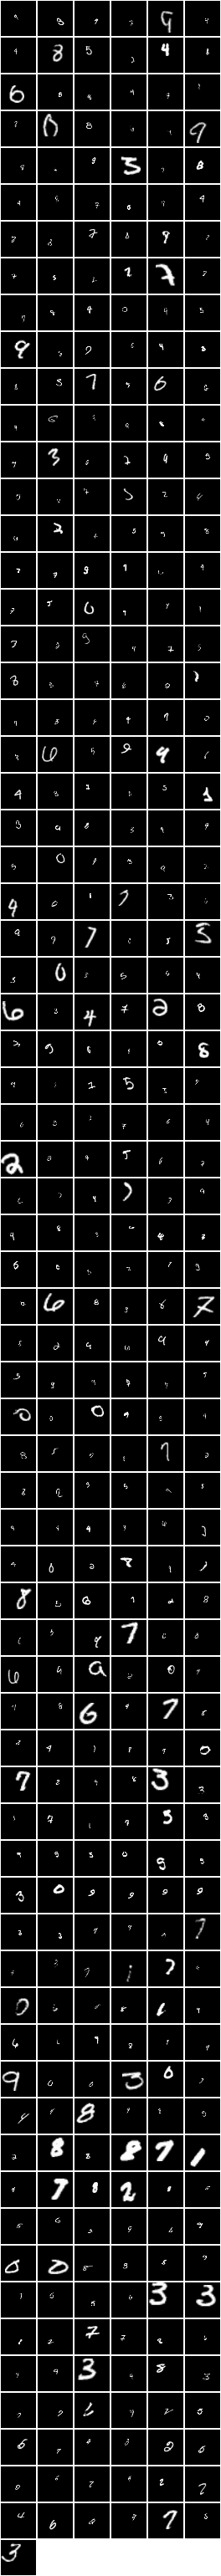

In [50]:
-- show hard examples
require 'image'

hard_examples_index = incorrect:narrow(2, 1, 1):nonzero()
hard_examples_index = hard_examples_index[{{}, {1}}]

hard_examples = torch.zeros(hard_examples_index:size(1), 1, 42, 42)

for i = 1, hard_examples_index:size(1) do
    index = torch.totable(hard_examples_index[i])
    index = index[1]
    hard_examples[i] = val[index]
end

itorch.image(hard_examples)